This notebook is the continuation of the [Part 1 - Time Series Forecasting with XGBoost](https://github.com/tiashamondal29/Time-Series-Forecasting-using-XGBoost/blob/b20d0678a52962935e141c139d2c28e2d37e116f/part-1-time-series-forecasting-XGBoost.ipynb). 

In this notebook, I have covered more advanced methods such as 

* outlier removal
* time series cross validation 
* lag features
* Future Predictions



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

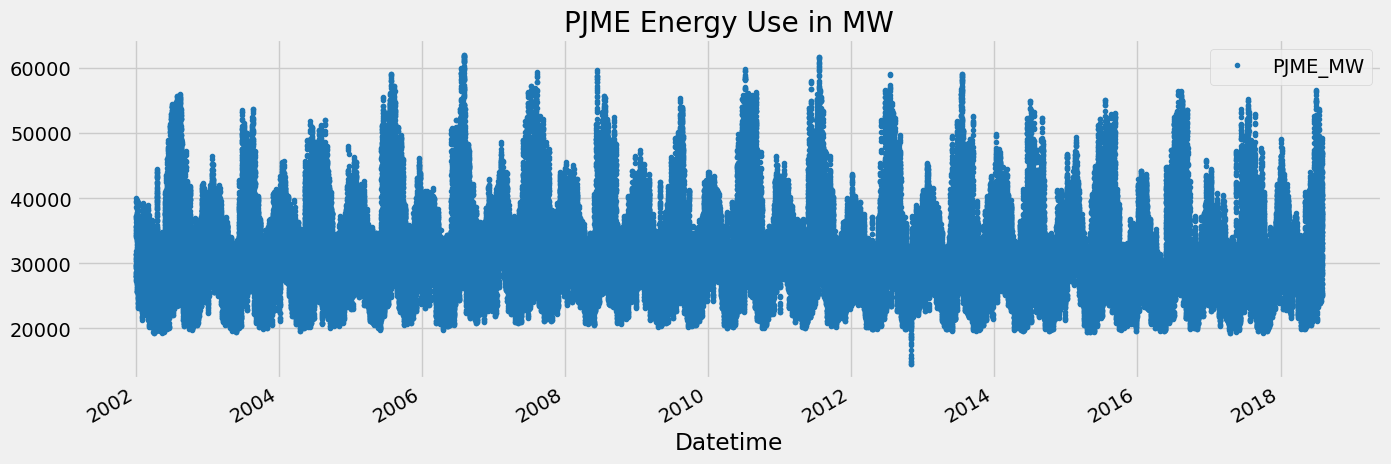

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# **1. Outlier Analysis Removal**

As we can see from the above graph, the values of Energy use in between 2012 and 2014 is really low and seems like outliers. 

Outliers can have a significant impact on statistical measures and model performance. Removing outliers can help to:

* Improve the accuracy and reliability of statistical analysis and modeling results.
* Reduce the impact of noise and anomalies on the interpretation of the data.

Therefore, in the next step, we are gonna remove the outliers.

<Axes: ylabel='Frequency'>

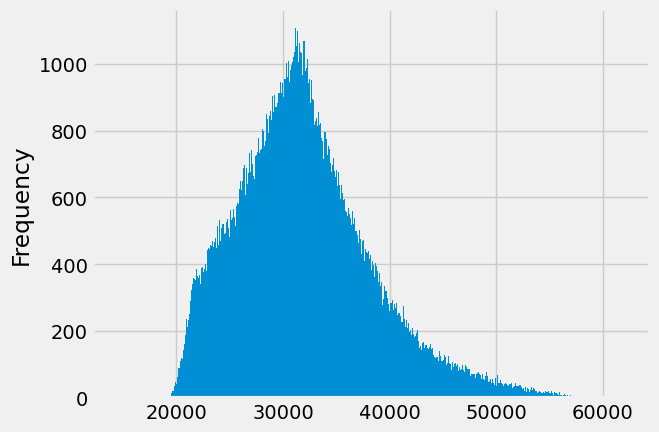

In [4]:
# Plotting the histogram of the Energy data 
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

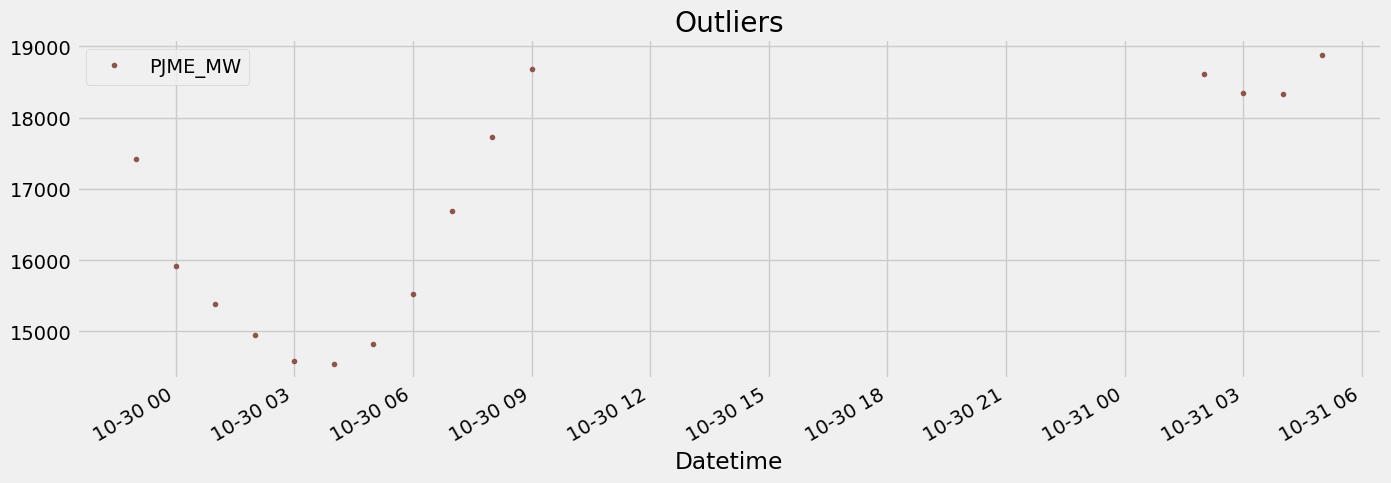

In [5]:
# Checking for Outliers
df.query('PJME_MW < 19000').plot(style='.',figsize=(15, 5),color=color_pal[5],title='Outliers')

From the above graph, we can confirm the presence of the outliers in between 2012 and 2014, the exceptional decrease of the energy. 

# **Reviewing: Train / Test Split**

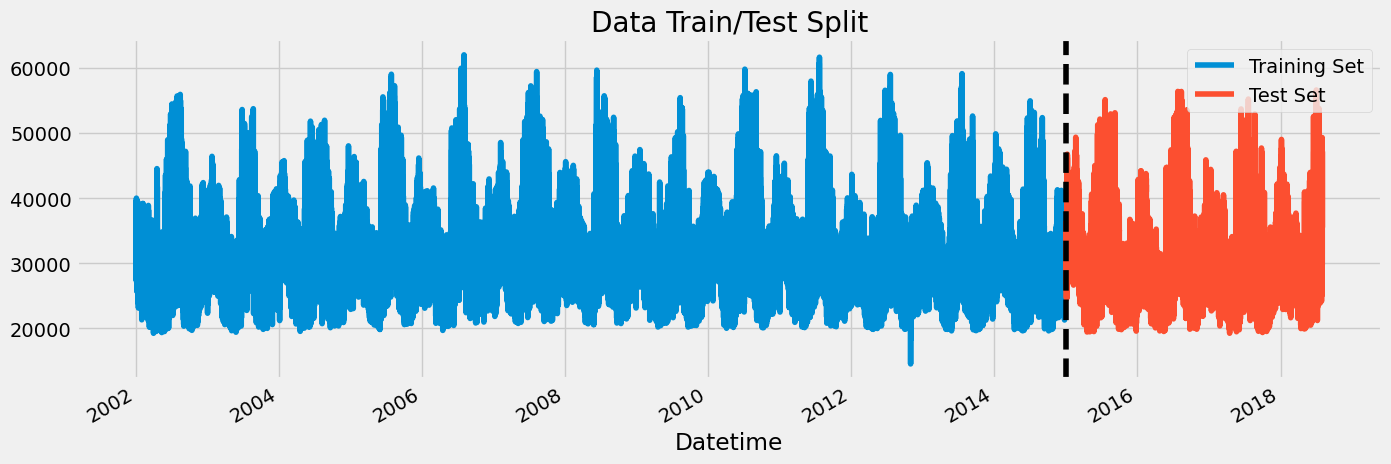

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# **2. Time Series Cross-validation**

In [7]:
from sklearn.model_selection import TimeSeriesSplit

# Performing 5-fold cross-validation.
# Test Data is set to one year of Energy data
# Leaving a gap of 1 Day(24 hours) time steps between the training and test sets.

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

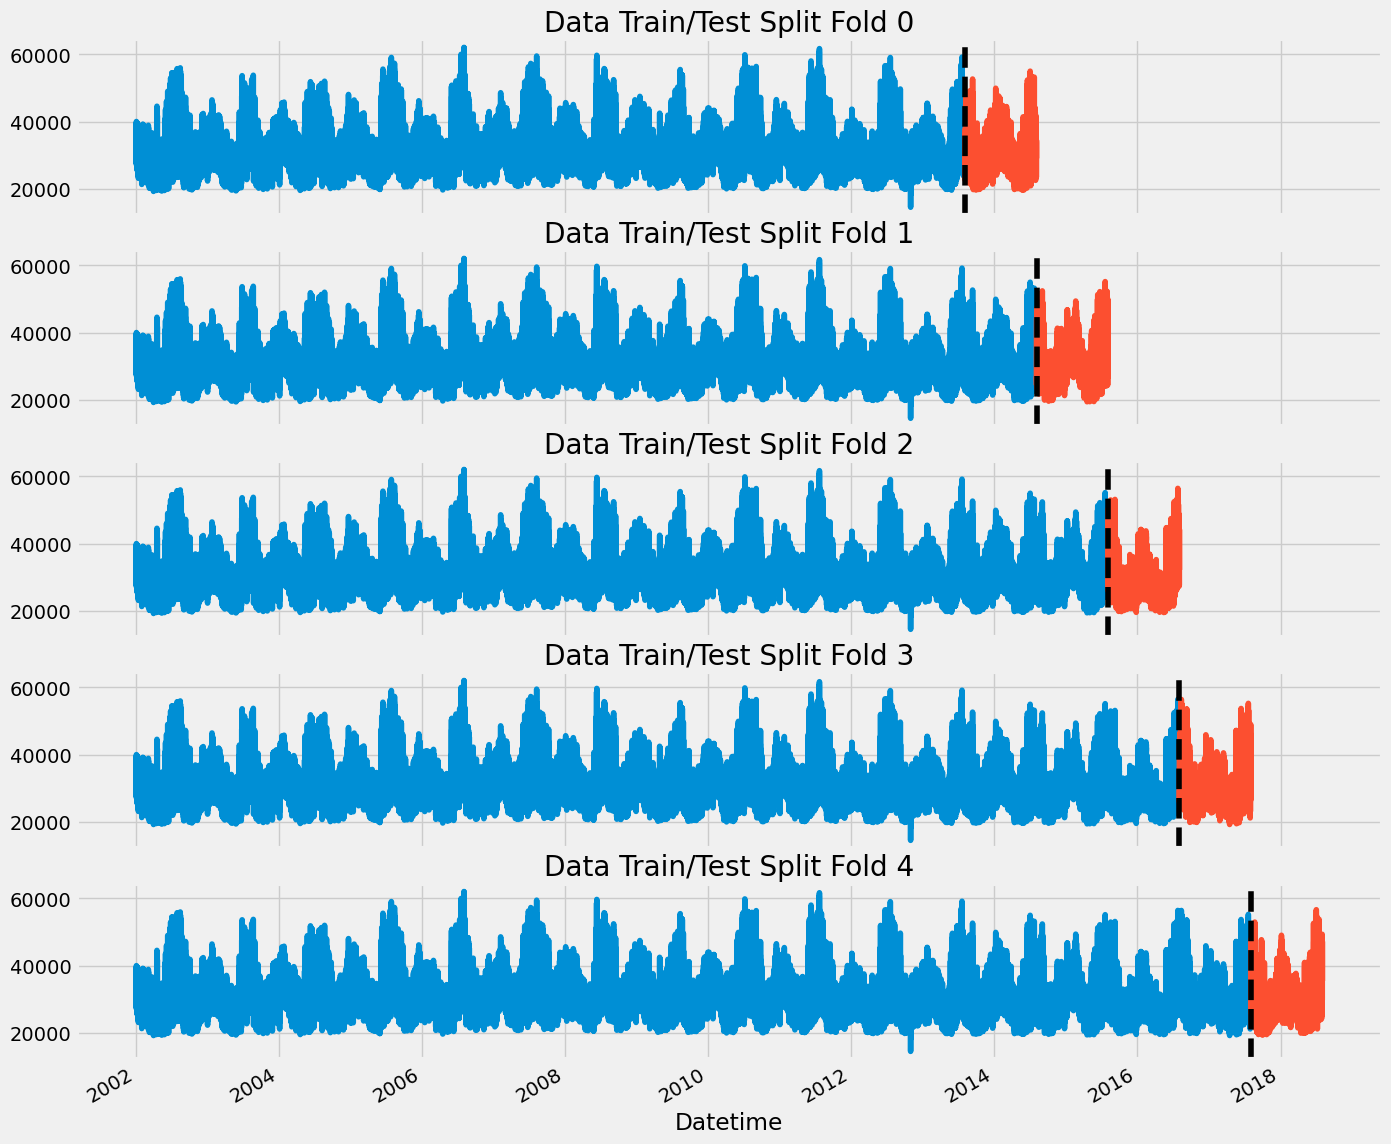

In [8]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# **2. Forecasting Horizon Explained**

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# **3. Lag Features**
What was the target (x) days in the past

In [10]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df


In [11]:
df = add_lags(df)

# **Train Using Cross Validation¶**

In [12]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[22:16:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32730.71054	validation_1-rmse:31956.75630
[100]	validation_0-rmse:12532.14660	validation_1-rmse:11907.51481
[200]	validation_0-rmse:5744.29363	validation_1-rmse:5356.76730
[300]	validation_0-rmse:3867.98731	validation_1-rmse:3894.92676
[400]	validation_0-rmse:3432.78115	validation_1-rmse:3757.49592
[468]	validation_0-rmse:3340.69128	validation_1-rmse:3765.23730
[22:16:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32670.51840	validation_1-rmse:32138.89448
[100]	validation_0-rmse:12513.25084	validation_1-rmse:12221.99536
[200]	validation_0-rmse:5755.65804	validation_1-rmse:5644.38325
[300]	validation_0-rmse:3907.32717	validation_1-rmse:3931.02169
[400]	validation_0-rmse:3478.34430	validation_1-rmse:3597.88619
[500]	validation_0-rmse:3356.80347	validation_1-rmse:3

# **4. Predicting the Future**
Retraining on all data.

To Predict the future we need an emtpy dataframe for future date ranges.

Run those dates through our feature creation code + lag creation


In [13]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[22:18:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32402.65859
[100]	validation_0-rmse:12426.28053
[200]	validation_0-rmse:5751.94624
[300]	validation_0-rmse:3972.75300
[400]	validation_0-rmse:3573.05471
[499]	validation_0-rmse:3457.78460


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [14]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [15]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [16]:
future_w_features = df_and_future.query('isFuture').copy()

# **Predict the future¶**

In [17]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

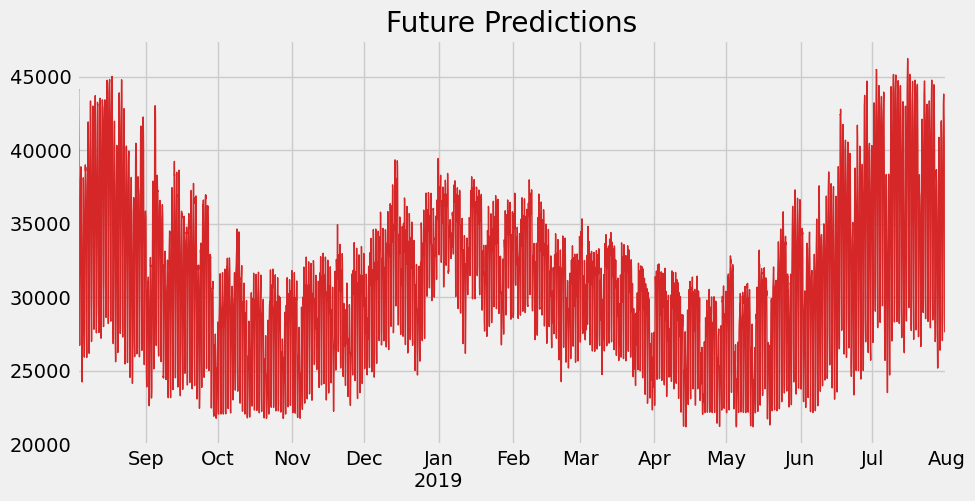

In [18]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()


# **Saving Model For later**

In [19]:
# Save model
reg.save_model('model.json')

In [20]:
!ls -lh

total 1.3M
---------- 1 root root 742K Jun  8 22:19 __notebook__.ipynb
-rw-r--r-- 1 root root 572K Jun  8 22:19 model.json


<Axes: title={'center': 'Future Predictions'}>

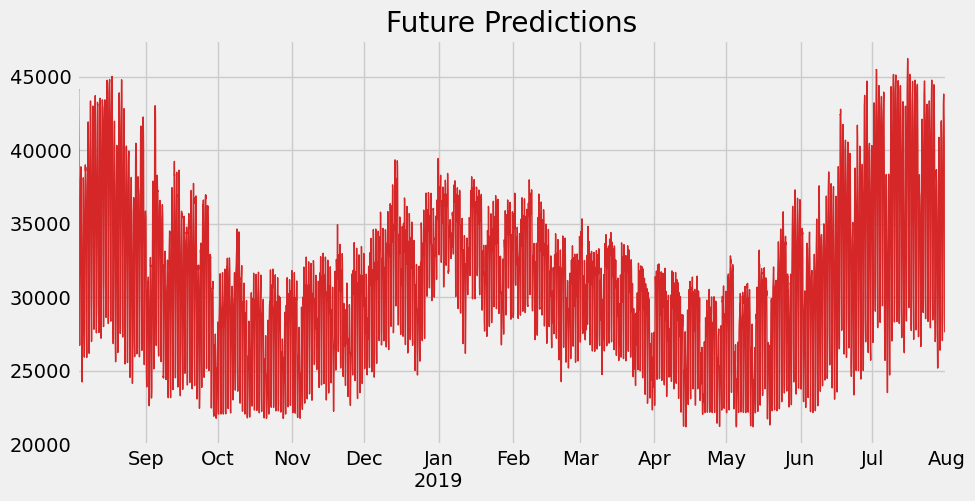

In [21]:
#Double checking the same prediction on the new saved model
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1, lw=1,
                               title='Future Predictions')